In [75]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from natsort import natsorted, ns
from functools import reduce

In [76]:
n_revision_list = np.array([])
max_nodes_list = np.array([])
variance_list = np.array([])
difference_list = np.array([])
addition_deletion_list = np.array([])

In [113]:
def array_statistics(ar):
    ds = stats.describe(ar)
    print('Mean:', ds.mean, end='   ')
    print('Min/Max:', ds.minmax, end='   ')
    print('Variance:', ds.variance)
    qt = np.percentile(ar, [25, 50, 75])
    print('1st Quartile:', qt[0], end='     ')
    print('Median:', qt[1], end='     ')
    print('3rd Quartile:', qt[2])
    
    

In [77]:
root_path = '/home/eduardo/Desktop/new_datasets/WB/'
dataset_paths = [x[0] for x in os.walk(root_path) if x[0] != root_path]
# dataset_paths[:6]

In [82]:
n_datasets = len(dataset_paths)
for path in dataset_paths:
    print(str(n_datasets) + '    ', end='\r', flush=True)
    n_datasets -= 1
    #path = dataset_paths[500]
    revision_paths = natsorted(os.listdir(path))
    revision_paths = [path + '/' + i for i in revision_paths]
    n_revisions = len(revision_paths)
    n_revision_list = np.append(n_revision_list, n_revisions)

    # Build different csv files into a single table
    dfs = [pd.read_csv(rev, index_col='id', header=0, names=['id', rev[-8:-4]]) for rev in revision_paths]
    df = reduce(lambda left,right: pd.merge(left,right,how='outer', left_index=True, right_index=True), dfs)
    # display(df.head())

    # Max number of cells in a revision
    max_nodes_list = np.append(max_nodes_list, df.notnull().sum(axis=0).max())
    
    # Normalize each column of table
    for column in df:
        column_sum = df[column].sum()
        df[column] = df[column] / column_sum

    # Variance of all cells
    variance_list = np.append(variance_list, df.unstack().var())
    
    # Compute cell diff between consecutive revisions
    diffs = np.diff(df.values, axis=1).flatten()
    diffs = diffs[~np.isnan(diffs)]
    for value in np.absolute(diffs):
        difference_list = np.append(difference_list, value)
    
    # Count additions and deletions (no distinction between the two)
    addition_deletion_count = 0
    for i in range(n_revisions - 1):
        addition_deletion_count += np.logical_xor(df.iloc[:, i].notnull(), df.iloc[:, i + 1].notnull()).sum()
    addition_deletion_list = np.append(addition_deletion_list, addition_deletion_count)


In [ ]:
# All datasets have the same depth = 2.  Region/Country

Mean: 38.1505631298   Min/Max: (1.0, 58.0)   Variance: 316.819547429
1st Quartile: 22.0     Median: 47.0     3rd Quartile: 56.0


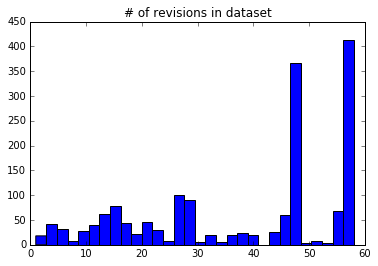

In [120]:
plt.hist(n_revision_list, bins=30);
plt.title('# of revisions in dataset')
array_statistics(n_revision_list)

Mean: 132.161232958   Min/Max: (0.0, 217.0)   Variance: 3131.77114154
1st Quartile: 89.0     Median: 140.0     3rd Quartile: 185.0


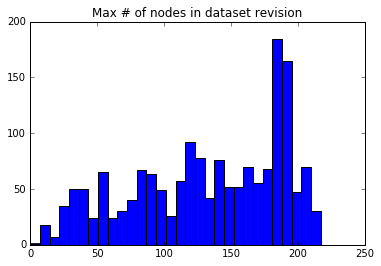

In [119]:
plt.hist(max_nodes_list, bins=30)
plt.title('Max # of nodes in dataset revision')
array_statistics(max_nodes_list)

Mean: 0.00301439932575   Min/Max: (8.653095497811932e-10, 0.08823312799614616)   Variance: 4.53468523336e-05
1st Quartile: 5.65687002194e-05     Median: 0.000446665275147     3rd Quartile: 0.0021336102418


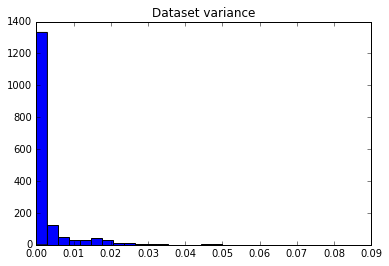

In [121]:
variance_list =  variance_list[~np.isnan(variance_list)]
plt.hist(variance_list, bins=30)
plt.title('Dataset variance')
array_statistics(variance_list)


Mean: 0.00180129688302   Min/Max: (0.0, 0.99996715037736006)   Variance: 0.000137232823192
1st Quartile: 2.37910797288e-05     Median: 0.00013832542046     3rd Quartile: 0.000765977360963


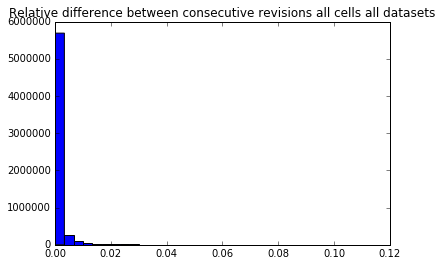

In [127]:
plt.hist(difference_list, bins=30, range=[0,0.1])
plt.title('Relative difference between consecutive revisions all cells all datasets')
array_statistics(difference_list)

In [86]:
np.savetxt('n_revision_list.csv', n_revision_list, delimiter=',')
np.savetxt('max_nodes_list.csv', max_nodes_list, delimiter=',')
np.savetxt('variance_list.csv', variance_list, delimiter=',')
np.savetxt('difference_list.csv', difference_list, delimiter=',')
np.savetxt('addition_deletion_list.csv', addition_deletion_list, delimiter=',')